# Peak-hour analysis

We first read the CSV files that were exported from merging traffic and demand data. Two files are produced, one for actual times (without cancelled trips) and one for planned time (larger file).

In [3]:
import pandas as pd

# Read the CSV file
#df_onboard_planned = pd.read_csv('df_onboard_planned.csv') ### passenger onboard estimated using PLANNED departure times
df_onboard_actual = pd.read_csv('df_onboard_actual.csv') ## passenger onboard estimated using ACTUAL departure times

We want to study passenger punctuality using different metrics during off-peak time period of the day (9-15).

### Filtering data (oustide off-peak)

Let us first filter out the observations outside middday off-peak hours. We remove all trains that first departure outside these hours.

In [4]:
# Step 1: Group the data by 'Datum', 'Taguppdrag', 'Tagnr'
grouped_actual = df_onboard_actual.groupby(['Datum', 'Taguppdrag', 'Tagnr'])

# Step 2: Filter out groups based on the first departure time
def filter_by_departure_time(group, earliest_time, latest_time):
    # Get the first departure's dep_t_float value
    first_dep = group[group['UppehallstypAvgang'] == 'Första']['dep_t_float']
    
    # Check if the first departure exists and is within the specified range
    if not first_dep.empty:
        first_dep_time = first_dep.iloc[0]
        return earliest_time <= first_dep_time <= latest_time
    
    # If no 'Första' is found, exclude the group
    return False

# Define the time range in terms of 'dep_t_float'
earliest_time_morning = 6 * 4  # 6 AM
earliest_time_afternoon = 15 * 4  # 15 
latest_time_morning = 9 * 4   # 9 AM
latest_time_afternoon = 18 * 4   # 18

# Step 3: Filter the original DataFrame to keep only the groups that match the condition
df_onboard_actual_morning = grouped_actual.filter(
    lambda x: filter_by_departure_time(x, earliest_time_morning, latest_time_morning)
    ).reset_index(drop=True)
df_onboard_actual_afternoon = grouped_actual.filter(
    lambda x: filter_by_departure_time(x, earliest_time_afternoon, latest_time_afternoon)
    ).reset_index(drop=True)

### Average train ridership per direction

Let us plot the average train ridership between consecutive station per direction.

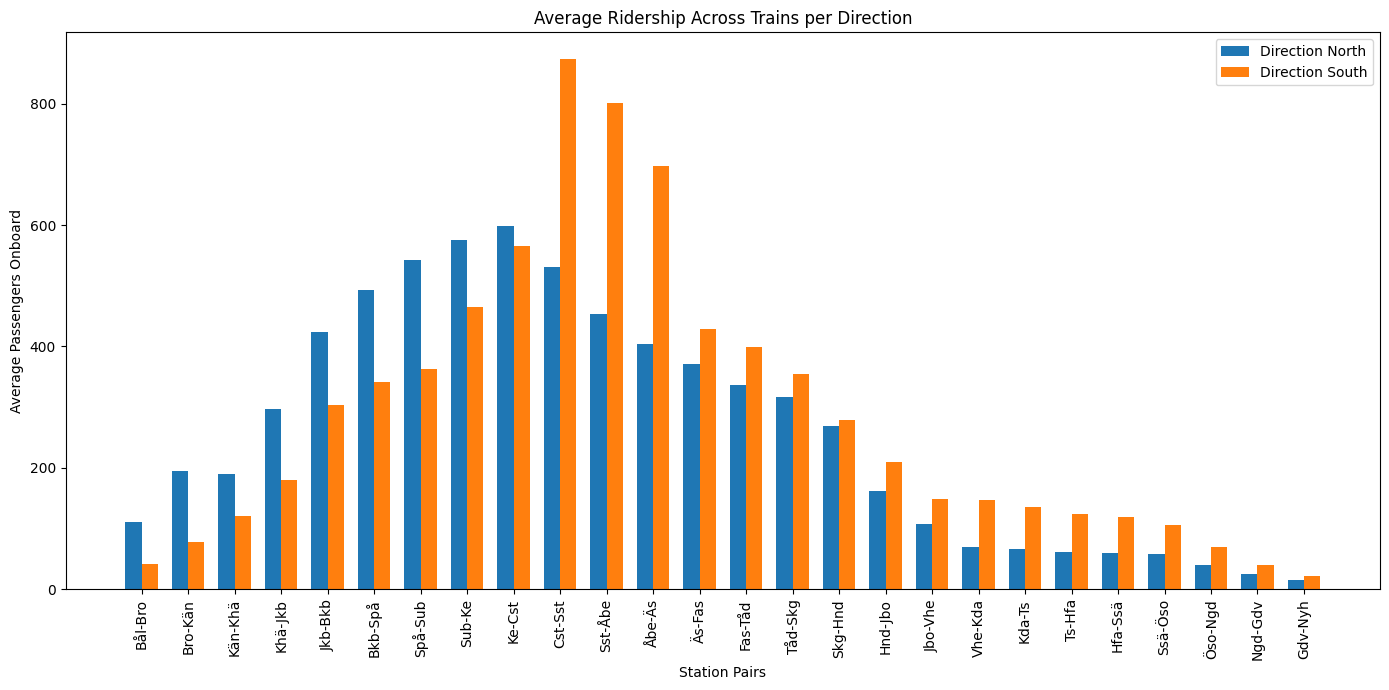

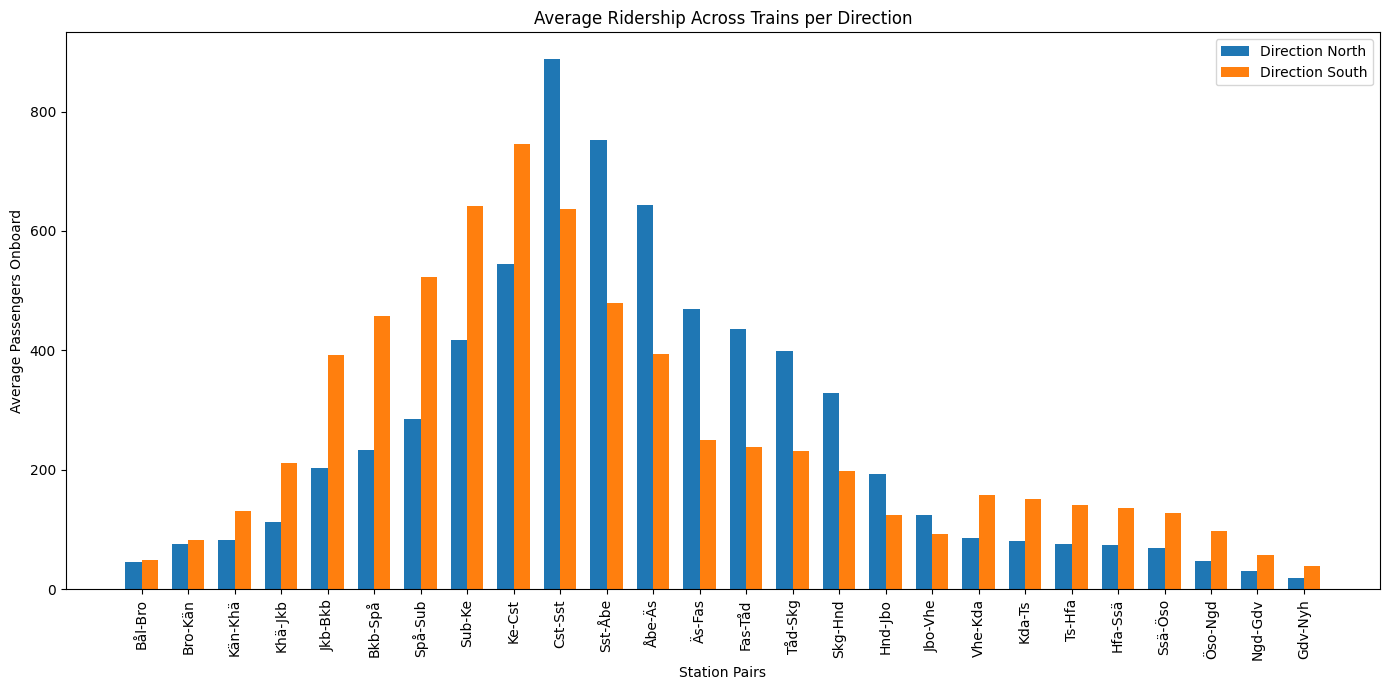

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_ridership(df):
    # List of stations from north to south
    stations_north_to_south = ['Bål', 'Bro', 'Kän', 'Khä', 'Jkb', 'Bkb', 'Spå', 'Sub', 'Ke', 'Cst', 'Sst', 'Åbe', 'Äs',
                            'Fas', 'Tåd', 'Skg', 'Hnd', 'Jbo', 'Vhe', 'Kda', 'Ts', 'Hfa', 'Ssä', 'Öso', 'Ngd', 'Gdv', 'Nyh']

    # Step 1: Create pairs of consecutive stations
    station_pairs_north_to_south = [(stations_north_to_south[i], stations_north_to_south[i+1]) for i in range(len(stations_north_to_south) - 1)]
    station_pairs_south_to_north = [(to, from_) for from_, to in station_pairs_north_to_south]

    # Combine the two sets of pairs into a DataFrame
    station_pairs_df = pd.DataFrame({
        'pair_north_to_south': [f"{from_}-{to}" for from_, to in station_pairs_north_to_south],
        'pair_south_to_north': [f"{from_}-{to}" for from_, to in station_pairs_south_to_north]
    })

    # Step 2: Group by direction and pairs of consecutive stations
    df_grouped = df.groupby(['direction', 'Fran_platssignatur', 'Till_platssignatur'])['n_onboard'].mean().reset_index()

    # Step 3: Assign pairs and filter by valid pairs
    df_grouped['pair'] = df_grouped.apply(
        lambda row: f"{row['Fran_platssignatur']}-{row['Till_platssignatur']}" 
        if row['direction'] == -1 else f"{row['Till_platssignatur']}-{row['Fran_platssignatur']}", axis=1
    )

    # Filter valid pairs
    valid_pairs = station_pairs_df['pair_north_to_south'].tolist() + station_pairs_df['pair_south_to_north'].tolist()
    df_grouped_filtered = df_grouped[df_grouped['pair'].isin(valid_pairs)].copy()

    # Step 4: Order by the station pairs for the x-axis
    df_grouped_filtered['pair_order'] = pd.Categorical(df_grouped_filtered['pair'], 
                                                    categories=station_pairs_df['pair_north_to_south'].tolist() + station_pairs_df['pair_south_to_north'].tolist(), 
                                                    ordered=True)
    df_grouped_filtered = df_grouped_filtered.sort_values('pair_order')

    # Step 5: Prepare data for the bar chart
    northbound_data = df_grouped_filtered[df_grouped_filtered['direction'] == 1].set_index('pair_order')['n_onboard']
    southbound_data = df_grouped_filtered[df_grouped_filtered['direction'] == -1].set_index('pair_order')['n_onboard']

    # Ensure all pairs are included for both directions (fill with 0 if missing)
    northbound_data = northbound_data.reindex(station_pairs_df['pair_south_to_north'].tolist(), fill_value=0)
    southbound_data = southbound_data.reindex(station_pairs_df['pair_south_to_north'].tolist(), fill_value=0)

    # Step 6: Plot the bar chart
    bar_width = 0.35
    index = np.arange(len(station_pairs_df['pair_north_to_south']))

    plt.figure(figsize=(14, 7))
    plt.bar(index, northbound_data, bar_width, label='Direction North')
    plt.bar(index + bar_width, southbound_data, bar_width, label='Direction South')

    plt.xticks(index + bar_width / 2, station_pairs_df['pair_north_to_south'].tolist(), rotation=90)
    plt.xlabel('Station Pairs')
    plt.ylabel('Average Passengers Onboard')
    plt.title('Average Ridership Across Trains per Direction')
    plt.legend()
    plt.tight_layout()

    plt.show()
plot_ridership(df_onboard_actual_morning)
plot_ridership(df_onboard_actual_afternoon)

### Calculating travel time distributions

We have among others the following information, i.e., 'Taguppdrag', 'Tagnr', 'Datum', 'UppehallstypAvgang', 'UppehallstypAnkomst', 'Delstrackanummer', 'Fran_platssignatur', 'Till_platssignatur', 'Ankomsttid', 'Avgangstid', 'Planerad_ankomsttid', 'Planerad_avgangstid', 'dep_delay', 'arr_delay', 'dep_t_float', 'arr_t_float', 'dep_delay_minutes', 'arr_delay_minutes', 'direction', 'n_onboard', 'n_boarding', 'n_alighting', 'n_alighting_next.


We also have columns with station signature with information on the number of passengers boarding towards these stations.


We want to find the travel time distributions between every pair of stations in the studied line.
For each direction (+1 or -1), we will go over every train (identified by 'Taguppdrag', 'Tagnr', 'Datum') and all the stations in order (of Delstrackanummer). We will fill in a dataframe with for each train, the following columns: from_station, to_station, Number passengers traveling between these stations, and the planned travel time (Planerad_ankomsttid to to_station - Planerad_avgangstid from from_station), and the actual travel time similarly but Ankomsttid - Avgangstid.

In [6]:
import pandas as pd

# List of stations from south to north
stations_south_to_north = ['Bål', 'Bro', 'Kän', 'Khä', 'Jkb', 'Bkb', 'Spå', 'Sub', 'Ke', 'Cst', 'Sst', 'Åbe', 'Äs',
                           'Fas', 'Tåd', 'Skg', 'Hnd', 'Jbo', 'Vhe', 'Kda', 'Ts', 'Hfa', 'Ssä', 'Öso', 'Ngd', 'Gdv', 'Nyh']

# Convert relevant columns to datetime
df_onboard_actual_morning['Planerad_ankomsttid'] = pd.to_datetime(df_onboard_actual_morning['Planerad_ankomsttid'], errors='coerce')
df_onboard_actual_morning['Planerad_avgangstid'] = pd.to_datetime(df_onboard_actual_morning['Planerad_avgangstid'], errors='coerce')
df_onboard_actual_morning['Ankomsttid'] = pd.to_datetime(df_onboard_actual_morning['Ankomsttid'], errors='coerce')
df_onboard_actual_morning['Avgangstid'] = pd.to_datetime(df_onboard_actual_morning['Avgangstid'], errors='coerce')

# Split the dataframe into northbound and southbound data
df_actual_morning_northbound = df_onboard_actual_morning[df_onboard_actual_morning['direction'] == 1]
df_actual_morning_southbound = df_onboard_actual_morning[df_onboard_actual_morning['direction'] == -1]

In [7]:
## we do the same for afternoon
df_onboard_actual_afternoon['Planerad_ankomsttid'] = pd.to_datetime(df_onboard_actual_afternoon['Planerad_ankomsttid'], errors='coerce')
df_onboard_actual_afternoon['Planerad_avgangstid'] = pd.to_datetime(df_onboard_actual_afternoon['Planerad_avgangstid'], errors='coerce')
df_onboard_actual_afternoon['Ankomsttid'] = pd.to_datetime(df_onboard_actual_afternoon['Ankomsttid'], errors='coerce')
df_onboard_actual_afternoon['Avgangstid'] = pd.to_datetime(df_onboard_actual_afternoon['Avgangstid'], errors='coerce')

# Split the dataframe into northbound and southbound data
df_actual_afternoon_northbound = df_onboard_actual_afternoon[df_onboard_actual_afternoon['direction'] == 1]
df_actual_afternoon_southbound = df_onboard_actual_afternoon[df_onboard_actual_afternoon['direction'] == -1]

In [8]:
def process_direction(df):
    grouped_trains = df.groupby(['Taguppdrag', 'Tagnr', 'Datum', 'direction'])

    df_travel_times_list = []

    for train_id, train_data in grouped_trains:
        train_data_sorted = train_data.sort_values(by='Delstrackanummer')

        # Pre-extract necessary columns
        fran_signatures = train_data_sorted['Fran_platssignatur'].values
        till_signatures = train_data_sorted['Till_platssignatur'].values
        scheduled_arrival_times = train_data_sorted['Planerad_ankomsttid'].values
        scheduled_departure_times = train_data_sorted['Planerad_avgangstid'].values
        arrival_times = train_data_sorted['Ankomsttid'].values
        departure_times = train_data_sorted['Avgangstid'].values
        headways = train_data_sorted['headway'].values

        # Use NumPy arrays to store row data for efficiency
        rows_list = []

        # Iterate over stations
        for i in range(len(train_data_sorted)):
            curr_from_station = fran_signatures[i]

            # Use slicing to avoid nested loop
            next_to_stations = till_signatures[i:]
            passengers_to_next = train_data_sorted.iloc[i][next_to_stations].values
            durations = (arrival_times[i:] - departure_times[i]).astype('timedelta64[m]').astype(int)
            scheduled_durations = (scheduled_arrival_times[i:] - scheduled_departure_times[i]).astype('timedelta64[m]').astype(int)

            # Construct rows
            for j in range(len(next_to_stations)):
                if durations[j]<0:
                    print(durations[j])
                rows_list.append((
                    train_id[0], train_id[1], train_id[2], train_id[3], 
                    curr_from_station, next_to_stations[j], headways[i],
                    passengers_to_next[j], durations[j], scheduled_durations[j]
                ))

        df_train = pd.DataFrame(rows_list, columns=[
            'Taguppdrag', 'Tagnr', 'Datum', 'direction',
            'Fran_platssignatur', 'Till_platssignatur', 'headway',
            'n_passengers', 'actual_travel_time', 'scheduled_travel_time'
        ])
        
        df_travel_times_list.append(df_train)
    
    return pd.concat(df_travel_times_list, ignore_index=True)

In [9]:
from joblib import Parallel, delayed

# Parallel execution for northbound and southbound data
results_actual_morning = Parallel(n_jobs=2)(delayed(process_direction)(df) for df in [df_actual_morning_northbound, df_actual_morning_southbound])
results_actual_afternoon = Parallel(n_jobs=2)(delayed(process_direction)(df) for df in [df_actual_afternoon_northbound, df_actual_afternoon_southbound])

# Combine the results
df_travel_times_actual_morning = pd.concat(results_actual_morning, ignore_index=True)
df_travel_times_actual_afternoon = pd.concat(results_actual_afternoon, ignore_index=True)

### Travel time percentile

We are going now to study the journey time percentiles. For that we look at one Origin Destination (OD) example and plot the actual travel time percentile on the x-axis and travel time in minutes on the y-axis.
We will also plot the line horizontal line corresponding to the average planned travel time on that OD pair.

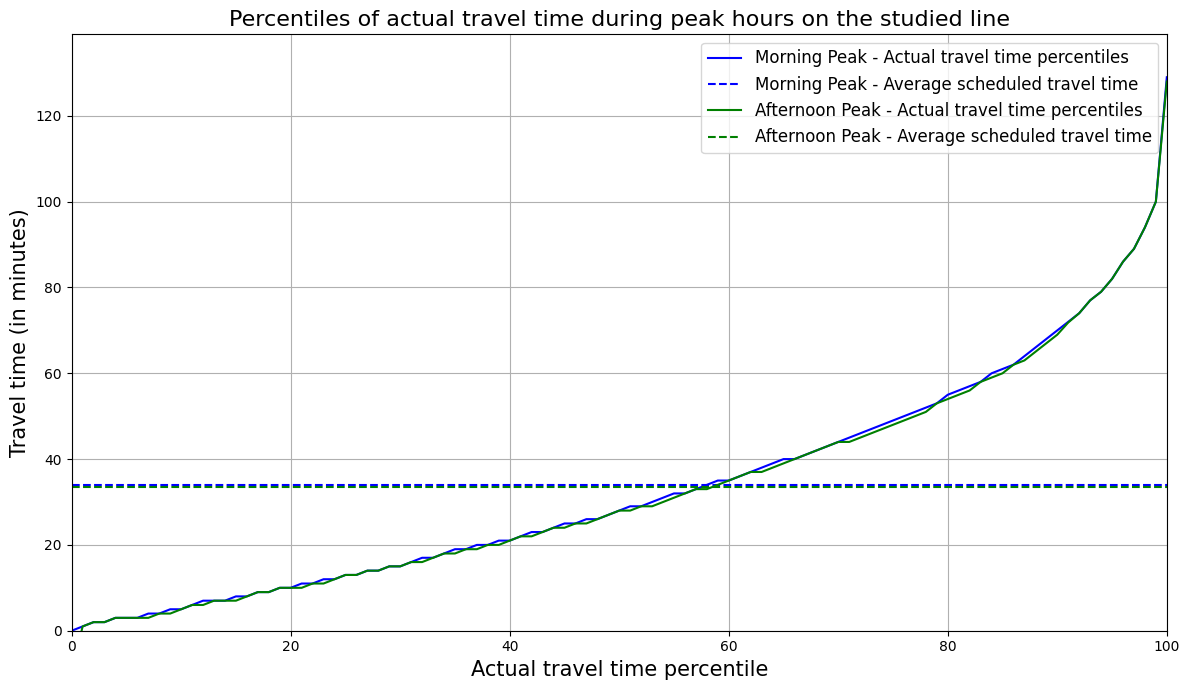

Morning Peak - Average scheduled travel time: 33.93 minutes
Morning Peak - Median Actual Travel Time: 28.00 minutes
Morning Peak - 90th Percentile Actual Travel Time: 70.00 minutes
Afternoon Peak - Average scheduled travel time: 33.44 minutes
Afternoon Peak - Median Actual Travel Time: 28.00 minutes
Afternoon Peak - 90th Percentile Actual Travel Time: 69.00 minutes


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate percentiles for the morning peak hours
morning_actual_travel_times = df_travel_times_actual_morning['actual_travel_time'].values
morning_percentiles = np.percentile(morning_actual_travel_times, np.arange(0, 101, 1))
avg_planned_travel_time_morning = df_travel_times_actual_morning['scheduled_travel_time'].mean()

# Calculate percentiles for the afternoon peak hours
afternoon_actual_travel_times = df_travel_times_actual_afternoon['actual_travel_time'].values
afternoon_percentiles = np.percentile(afternoon_actual_travel_times, np.arange(0, 101, 1))
avg_planned_travel_time_afternoon = df_travel_times_actual_afternoon['scheduled_travel_time'].mean()

# Plotting
plt.figure(figsize=(12, 7))

# Plot the percentiles of actual travel time for the morning peak hours
plt.plot(np.arange(0, 101, 1), morning_percentiles, label='Morning Peak - Actual travel time percentiles', color='blue')

# Plot the average planned travel time for the morning peak hours
plt.axhline(y=avg_planned_travel_time_morning, color='blue', linestyle='--', label='Morning Peak - Average scheduled travel time')

# Plot the percentiles of actual travel time for the afternoon peak hours
plt.plot(np.arange(0, 101, 1), afternoon_percentiles, label='Afternoon Peak - Actual travel time percentiles', color='green')

# Plot the average planned travel time for the afternoon peak hours
plt.axhline(y=avg_planned_travel_time_afternoon, color='green', linestyle='--', label='Afternoon Peak - Average scheduled travel time')

# Add labels and title
plt.xlabel('Actual travel time percentile', fontsize=15)
plt.ylabel('Travel time (in minutes)', fontsize=15)
plt.title('Percentiles of actual travel time during peak hours on the studied line', fontsize=16)

# Add legend
plt.legend(fontsize=12)
plt.xlim(0, 100)
plt.ylim(0, max(morning_percentiles.max(), afternoon_percentiles.max()) + 10)  # Adjust ylim based on data

# Show plot with grid and tight layout
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some statistics for morning peak hours
print(f"Morning Peak - Average scheduled travel time: {avg_planned_travel_time_morning:.2f} minutes")
print(f"Morning Peak - Median Actual Travel Time: {morning_percentiles[50]:.2f} minutes")
print(f"Morning Peak - 90th Percentile Actual Travel Time: {morning_percentiles[90]:.2f} minutes")

# Print some statistics for afternoon peak hours
print(f"Afternoon Peak - Average scheduled travel time: {avg_planned_travel_time_afternoon:.2f} minutes")
print(f"Afternoon Peak - Median Actual Travel Time: {afternoon_percentiles[50]:.2f} minutes")
print(f"Afternoon Peak - 90th Percentile Actual Travel Time: {afternoon_percentiles[90]:.2f} minutes")

### Calculation of Excess Journey Time (EJT)

We will first calculate the average Excess Journey Time (EJT) per OD-pair. For a given OD-pair, EJT on a certain train trip is the positive difference between actual travel time and scheduled travel time, i.e., it is zero when scheduled travel time is longer than actual travel time. The average EJT of a given OD-pair is the sum of EJT for all individual train trips divided by the total number of trips, average over all the trips.

In [11]:
import pandas as pd

# Function to calculate EJT for a given DataFrame
def calculate_ejt(df):
    # Step 1: Calculate the mean scheduled travel time for each OD pair
    df['mean_scheduled_travel_time'] = df.groupby(['Fran_platssignatur', 'Till_platssignatur'])['scheduled_travel_time'].transform('mean')

    # Step 2: Calculate the Excess Journey Time (EJT) for each trip using the OD pair's mean scheduled travel time
    df['EJT'] = (df['actual_travel_time'] - df['mean_scheduled_travel_time']).clip(lower=0)

    # Step 3: Group by Origin-Destination (OD) pairs and calculate the total EJT and the number of trips
    od_ejt_summary = df.groupby(['Fran_platssignatur', 'Till_platssignatur']).agg(
        total_ejt=('EJT', 'sum'),
        total_trips=('EJT', 'count')
    ).reset_index()

    # Step 4: Calculate the average EJT per OD-pair
    od_ejt_summary['average_ejt'] = od_ejt_summary['total_ejt'] / od_ejt_summary['total_trips']
    
    return od_ejt_summary

# Apply the function to both morning and afternoon DataFrames
od_ejt_summary_morning = calculate_ejt(df_travel_times_actual_morning)
od_ejt_summary_afternoon = calculate_ejt(df_travel_times_actual_afternoon)

# Step 5: Display the summaries
print("Morning Peak Hours OD EJT Summary:")
print(od_ejt_summary_morning)

print("\nAfternoon Peak Hours OD EJT Summary:")
print(od_ejt_summary_afternoon)


Morning Peak Hours OD EJT Summary:
    Fran_platssignatur Till_platssignatur   total_ejt  total_trips  \
0                  Bkb                Bro   22.000000          194   
1                  Bkb                Bål   24.000000          194   
2                  Bkb                Cst  209.000000          399   
3                  Bkb                Fas   68.000000          277   
4                  Bkb                Gdv  212.000000          164   
..                 ...                ...         ...          ...   
697                Öso                 Ts    8.000000          180   
698                Öso                Tåd    0.000000          164   
699                Öso                Vhe   28.230769          195   
700                Öso                 Äs   23.850515          194   
701                Öso                Åbe   59.391753          194   

     average_ejt  
0       0.113402  
1       0.123711  
2       0.523810  
3       0.245487  
4       1.292683  
..        

We plot these average EJTs as a heatmap between the different pairs of stations on the studied line.

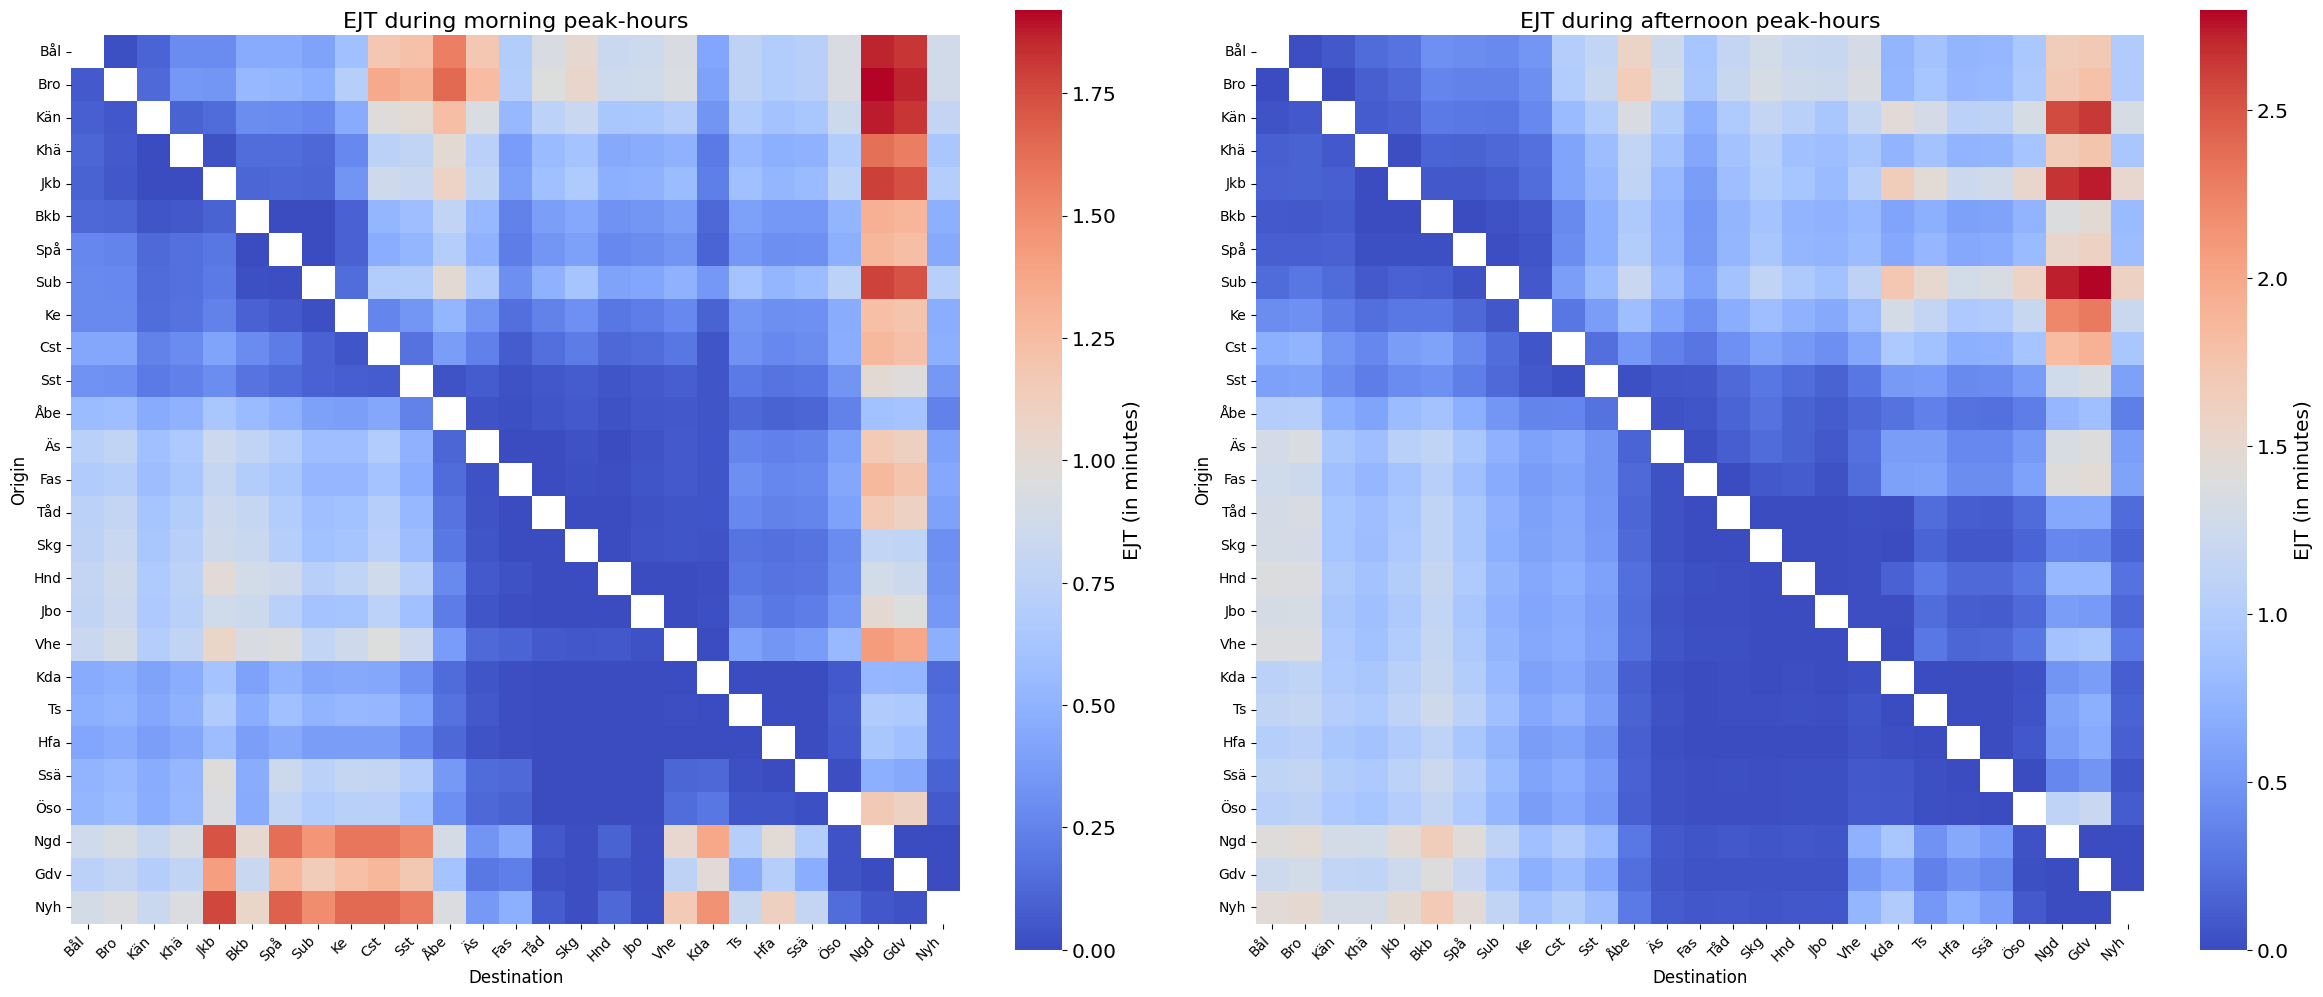

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming od_ejt_summary_morning and od_ejt_summary_afternoon are already calculated

# List of stations from south to north
stations_south_to_north = ['Bål', 'Bro', 'Kän', 'Khä', 'Jkb', 'Bkb', 'Spå', 'Sub', 'Ke', 'Cst', 'Sst', 'Åbe', 'Äs',
                           'Fas', 'Tåd', 'Skg', 'Hnd', 'Jbo', 'Vhe', 'Kda', 'Ts', 'Hfa', 'Ssä', 'Öso', 'Ngd', 'Gdv', 'Nyh']

# Pivot table for morning data
heatmap_data_morning = od_ejt_summary_morning.pivot_table(index='Fran_platssignatur', columns='Till_platssignatur', values='average_ejt')
heatmap_data_morning = heatmap_data_morning.reindex(index=stations_south_to_north, columns=stations_south_to_north)

# Pivot table for afternoon data
heatmap_data_afternoon = od_ejt_summary_afternoon.pivot_table(index='Fran_platssignatur', columns='Till_platssignatur', values='average_ejt')
heatmap_data_afternoon = heatmap_data_afternoon.reindex(index=stations_south_to_north, columns=stations_south_to_north)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
plt.rcParams['font.size'] = 14.5  # Set global font size
# Plot morning heatmap
sns.heatmap(heatmap_data_morning, cmap='coolwarm', annot=False, fmt=".1f", linewidths=.0, square=True, 
            cbar_kws={'label': 'EJT (in minutes)'}, ax=ax1)
ax1.set_title('EJT during morning peak-hours', fontsize=16)
ax1.set_xlabel('Destination', fontsize=12)
ax1.set_ylabel('Origin', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Plot afternoon heatmap
sns.heatmap(heatmap_data_afternoon, cmap='coolwarm', annot=False, fmt=".1f", linewidths=.0, square=True, 
            cbar_kws={'label': 'EJT (in minutes)'}, ax=ax2)
ax2.set_title('EJT during afternoon peak-hours', fontsize=16)
ax2.set_xlabel('Destination', fontsize=12)
ax2.set_ylabel('Origin', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

The previous heatmap does not consider n_passengers, i.e., unweighted average EJTs per OD-pair. Now, we gonna plot a similar heatmap showing passenger-weighted average EJTs.

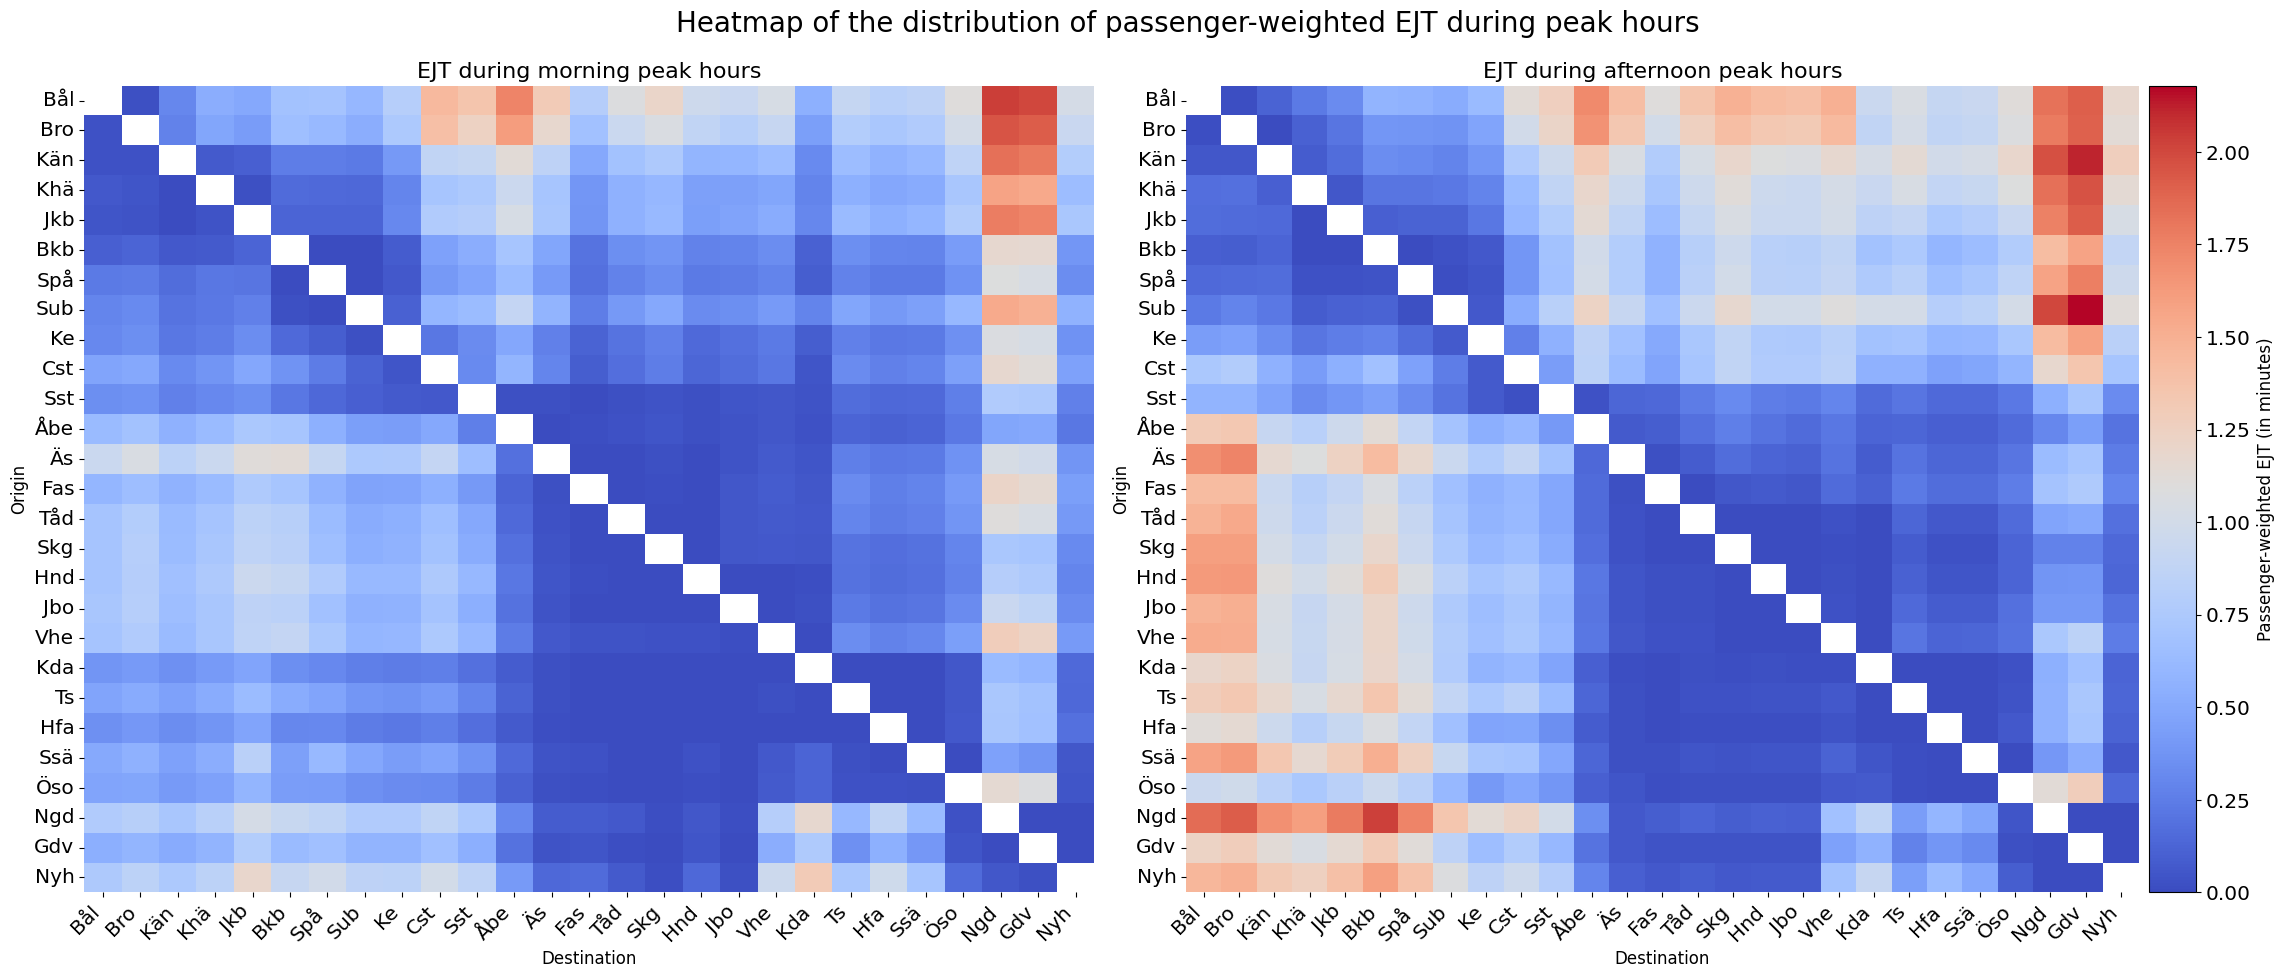

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

def process_data(df):
    # Step 1: Compute the EJT and weighted EJT for each journey
    df['EJT'] = np.maximum(df['actual_travel_time'] - df['scheduled_travel_time'], 0)
    df['weighted_ejt'] = df['EJT'] * df['n_passengers']

    # Step 2: Aggregate weighted EJTs and total passengers by OD-pair
    weighted_ejt_sum = df.groupby(['Fran_platssignatur', 'Till_platssignatur']).agg({
        'weighted_ejt': 'sum',
        'n_passengers': 'sum'
    }).reset_index()

    # Step 3: Calculate the passenger-weighted average EJT
    weighted_ejt_sum['passenger_weighted_avg_ejt'] = weighted_ejt_sum['weighted_ejt'] / weighted_ejt_sum['n_passengers']

    # Step 4: Pivot the data to create a matrix for the heatmap
    heatmap_data = weighted_ejt_sum.pivot_table(index='Fran_platssignatur', columns='Till_platssignatur', values='passenger_weighted_avg_ejt', aggfunc='mean')

    # Sort stations according to the order from south to north
    heatmap_data = heatmap_data.reindex(index=stations_south_to_north, columns=stations_south_to_north)

    return heatmap_data

# Process morning and afternoon data
heatmap_data_morning_weighted_avg_ejt = process_data(df_travel_times_actual_morning)
heatmap_data_afternoon_weighted_avg_ejt = process_data(df_travel_times_actual_afternoon)

# Find the global min and max for color scaling
vmin = min(heatmap_data_morning_weighted_avg_ejt.min().min(), heatmap_data_afternoon_weighted_avg_ejt.min().min())
vmax = max(heatmap_data_morning_weighted_avg_ejt.max().max(), heatmap_data_afternoon_weighted_avg_ejt.max().max())

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

plt.rcParams['font.size'] = 14.5  # Set global font size
# Create a normalization object
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot morning heatmap
sns.heatmap(heatmap_data_morning_weighted_avg_ejt, annot=False, cmap='coolwarm', linewidths=.0, linecolor='white', 
            cbar=False, ax=ax1, norm=norm)
ax1.set_title('EJT during morning peak hours', fontsize=16)
ax1.set_xlabel('Destination', fontsize=12)
ax1.set_ylabel('Origin', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Plot afternoon heatmap
sns.heatmap(heatmap_data_afternoon_weighted_avg_ejt, annot=False, cmap='coolwarm', linewidths=.0, linecolor='white', 
            cbar=False, ax=ax2, norm=norm)
ax2.set_title('EJT during afternoon peak hours', fontsize=16)
ax2.set_xlabel('Destination', fontsize=12)
ax2.set_ylabel('Origin', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

# Create a colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Passenger-weighted EJT (in minutes)', fontsize=12)

# Add a main title to the figure
fig.suptitle('Heatmap of the distribution of passenger-weighted EJT during peak hours', fontsize=20)

# Adjust layout
plt.tight_layout()

# Adjust the figure size to make room for the colorbar
fig.subplots_adjust(right=0.92)

# Show the plot
plt.show()

Now, we will calculate the average EJT across all the OD-pairs of the studied line by using the n_passengers traveling on the OD-pair as weights.

In [14]:
import numpy as np

# Assuming df_travel_times_actual_morning and df_travel_times_actual_afternoon have already been processed to include 'EJT' and 'n_passengers'

# Function to calculate weighted average EJT
def calculate_weighted_average_ejt(df):
    # Step 1: Calculate the weighted EJT for each OD-pair
    df['weighted_ejt'] = df['EJT'] * df['n_passengers']

    # Step 2: Sum up the total weighted EJT across all OD pairs
    total_weighted_ejt = df['weighted_ejt'].sum()

    # Step 3: Sum up the total number of passengers across all OD pairs
    total_passengers = df['n_passengers'].sum()

    # Step 4: Calculate the weighted average EJT across all OD pairs
    weighted_average_ejt = total_weighted_ejt / total_passengers

    return weighted_average_ejt

# Calculate weighted average EJT for morning and afternoon dataframes
weighted_average_ejt_morning = calculate_weighted_average_ejt(df_travel_times_actual_morning)
weighted_average_ejt_afternoon = calculate_weighted_average_ejt(df_travel_times_actual_afternoon)

# Step 5: Display the results
print(f"The weighted average EJT for the morning is: {weighted_average_ejt_morning:.2f} minutes")
print(f"The weighted average EJT for the afternoon is: {weighted_average_ejt_afternoon:.2f} minutes")

The weighted average EJT for the morning is: 0.46 minutes
The weighted average EJT for the afternoon is: 0.52 minutes


### OTP and PP2 metrics at 3-min delay threshold

To compare with the weighted average EJT across all OD-pairs, we calculate the OTP and PP2 scores at 3-min delay threshold (in percent).

In [15]:
import numpy as np

# Set the delay threshold
delay_threshold = 3  # minutes

# Function to calculate OTP and PP2
def calculate_otp_pp2(df):
    # Step 1: Calculate OTP (On-Time Performance)
    total_trips = len(df)
    trips_within_threshold = len(df[df['actual_travel_time'] - df['scheduled_travel_time'] <= delay_threshold])
    OTP_3min = (trips_within_threshold / total_trips) * 100

    # Step 2: Calculate PP2 (Passenger Punctuality)
    total_passengers = df['n_passengers'].sum()
    passengers_within_threshold = df[df['actual_travel_time'] - df['scheduled_travel_time'] <= delay_threshold]['n_passengers'].sum()
    PP2_3min = (passengers_within_threshold / total_passengers) * 100

    return OTP_3min, PP2_3min

# Calculate OTP and PP2 for morning and afternoon dataframes
OTP_3min_morning, PP2_3min_morning = calculate_otp_pp2(df_travel_times_actual_morning)
OTP_3min_afternoon, PP2_3min_afternoon = calculate_otp_pp2(df_travel_times_actual_afternoon)

# Display the results
print(f"OTP at 3-minute threshold for the morning: {OTP_3min_morning:.2f}%")
print(f"PP2 at 3-minute threshold for the morning: {PP2_3min_morning:.2f}%")
print(f"OTP at 3-minute threshold for the afternoon: {OTP_3min_afternoon:.2f}%")
print(f"PP2 at 3-minute threshold for the afternoon: {PP2_3min_afternoon:.2f}%")

OTP at 3-minute threshold for the morning: 96.53%
PP2 at 3-minute threshold for the morning: 96.13%
OTP at 3-minute threshold for the afternoon: 95.45%
PP2 at 3-minute threshold for the afternoon: 95.68%


We could also plot heatmaps for all OD-pairs to visualize the scores of OTP and PP2 for different pairs.

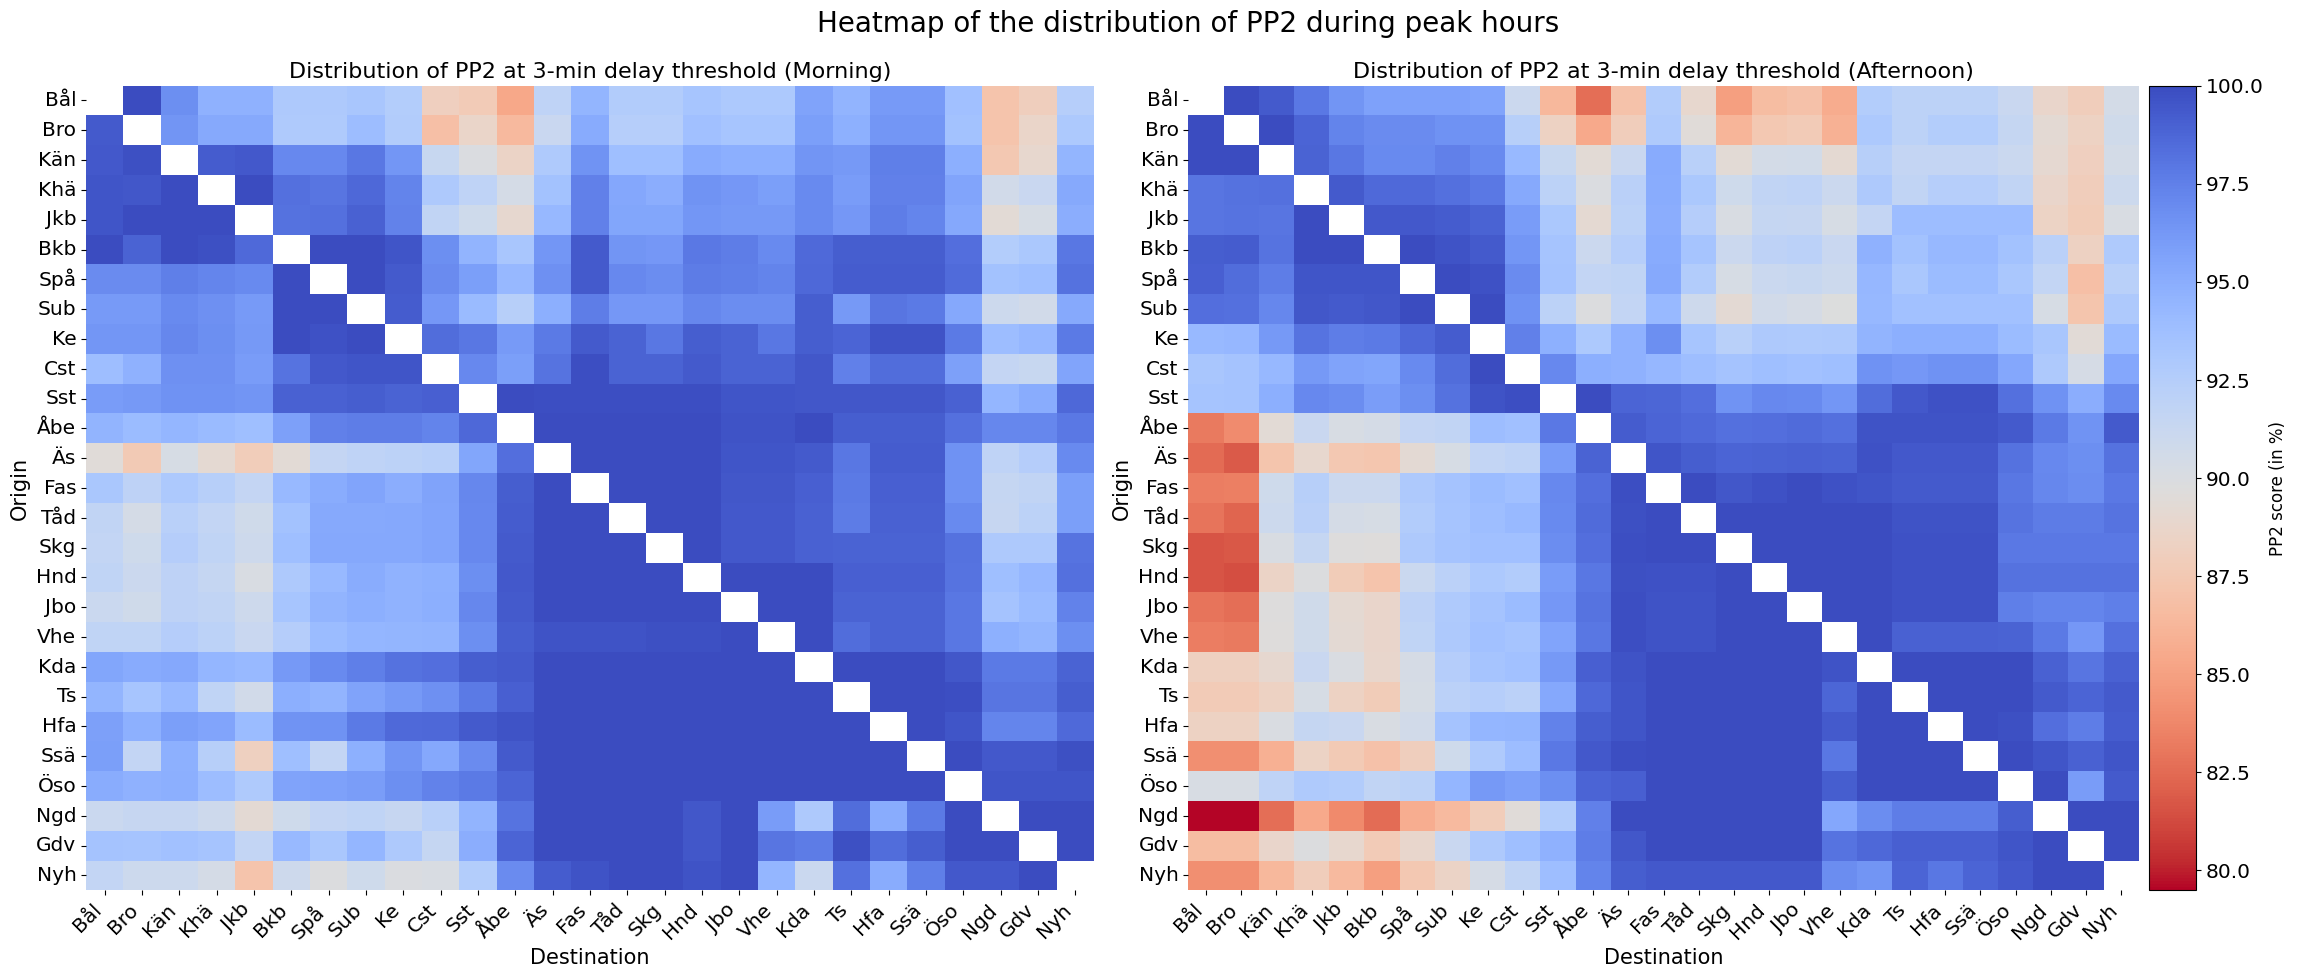

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set the delay threshold
delay_threshold = 3  # minutes

# Function to calculate PP2 for an OD-pair
def calculate_pp2(df):
    total_passengers = df['n_passengers'].sum()
    passengers_within_threshold = df[df['actual_travel_time'] - df['scheduled_travel_time'] <= delay_threshold]['n_passengers'].sum()
    PP2 = (passengers_within_threshold / total_passengers) * 100 if total_passengers > 0 else 0
    return PP2

# Process data for morning and afternoon
def process_data(df):
    pp2_by_od = df.groupby(['Fran_platssignatur', 'Till_platssignatur']).apply(calculate_pp2,include_groups=False).reset_index(name='PP2_3min')
    heatmap_data = pp2_by_od.pivot_table(index='Fran_platssignatur', columns='Till_platssignatur', values='PP2_3min')
    heatmap_data = heatmap_data.reindex(index=stations_south_to_north, columns=stations_south_to_north)
    return heatmap_data

# Process morning and afternoon data
heatmap_data_morning = process_data(df_travel_times_actual_morning)
heatmap_data_afternoon = process_data(df_travel_times_actual_afternoon)

# Find the global min and max for color scaling
vmin = min(heatmap_data_morning.min().min(), heatmap_data_afternoon.min().min())
vmax = max(heatmap_data_morning.max().max(), heatmap_data_afternoon.max().max())

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

plt.rcParams['font.size'] = 14.5  # Set global font size
# Create a normalization object
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot morning heatmap
sns.heatmap(heatmap_data_morning, annot=False, cmap='coolwarm_r', linewidths=.0, linecolor='white', 
            cbar=False, ax=ax1, norm=norm)
ax1.set_title('Distribution of PP2 at 3-min delay threshold (Morning)', fontsize=16)
ax1.set_xlabel('Destination', fontsize=15)
ax1.set_ylabel('Origin', fontsize=15)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Plot afternoon heatmap
sns.heatmap(heatmap_data_afternoon, annot=False, cmap='coolwarm_r', linewidths=.0, linecolor='white', 
            cbar=False, ax=ax2, norm=norm)
ax2.set_title('Distribution of PP2 at 3-min delay threshold (Afternoon)', fontsize=16)
ax2.set_xlabel('Destination', fontsize=15)
ax2.set_ylabel('Origin', fontsize=15)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

# Create a colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('PP2 score (in %)', fontsize=12)

# Add a main title to the figure
fig.suptitle('Heatmap of the distribution of PP2 during peak hours', fontsize=20)

# Adjust layout
plt.tight_layout()

# Adjust the figure size to make room for the colorbar
fig.subplots_adjust(right=0.92)

# Show the plot
plt.show()

### PP2 versus average EJT (scatter plot)

Now that we have calculated average EJTs and PP2 for different OD-pairs. It can be interesting to plot them together in a scatter plot. Different points correspond to different OD-pairs.

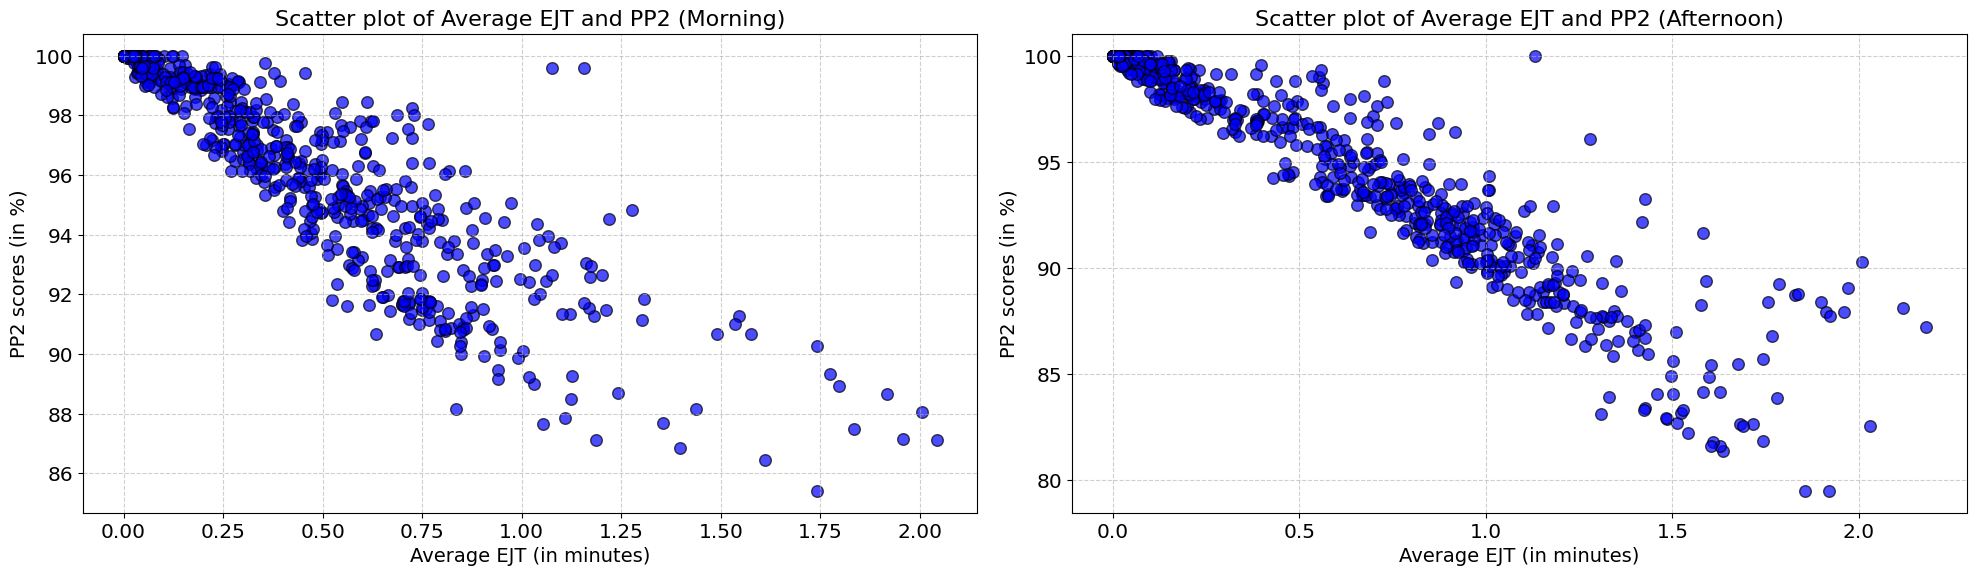

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the delay threshold
delay_threshold = 3  # minutes

# Function to calculate PP2 for an OD-pair
def calculate_pp2(df):
    total_passengers = df['n_passengers'].sum()
    passengers_within_threshold = df[df['actual_travel_time'] - df['scheduled_travel_time'] <= delay_threshold]['n_passengers'].sum()
    PP2 = (passengers_within_threshold / total_passengers) * 100 if total_passengers > 0 else 0
    return PP2

# Process data for morning and afternoon
def process_data(df):
    pp2_by_od = df.groupby(['Fran_platssignatur', 'Till_platssignatur']).apply(calculate_pp2,include_groups=False).reset_index(name='PP2_3min')
    return pp2_by_od

# Calculate PP2 for morning and afternoon data
pp2_by_od_morning = process_data(df_travel_times_actual_morning)
pp2_by_od_afternoon = process_data(df_travel_times_actual_afternoon)

# Calculate weighted EJT sum for morning and afternoon data
def calculate_weighted_ejt_sum(df):
    df['weighted_ejt'] = df['EJT'] * df['n_passengers']
    weighted_ejt_sum = df.groupby(['Fran_platssignatur', 'Till_platssignatur']).agg({
        'weighted_ejt': 'sum',
        'n_passengers': 'sum'
    }).reset_index()
    weighted_ejt_sum['passenger_weighted_avg_ejt'] = weighted_ejt_sum['weighted_ejt'] / weighted_ejt_sum['n_passengers']
    return weighted_ejt_sum

weighted_ejt_sum_morning = calculate_weighted_ejt_sum(df_travel_times_actual_morning)
weighted_ejt_sum_afternoon = calculate_weighted_ejt_sum(df_travel_times_actual_afternoon)

# Prepare the data for the scatter plot
scatter_data_morning = weighted_ejt_sum_morning[['passenger_weighted_avg_ejt']].copy()
scatter_data_afternoon = weighted_ejt_sum_afternoon[['passenger_weighted_avg_ejt']].copy()

# Reset index to align with scatter_data
scatter_data_morning['PP2_3min'] = pp2_by_od_morning['PP2_3min'].reset_index(drop=True)
scatter_data_afternoon['PP2_3min'] = pp2_by_od_afternoon['PP2_3min'].reset_index(drop=True)

# Drop any OD-pairs with missing data (optional, depending on your data quality)
scatter_data_morning = scatter_data_morning.dropna()
scatter_data_afternoon = scatter_data_afternoon.dropna()

# Create the scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Scatter plot for morning data
ax1.scatter(scatter_data_morning['passenger_weighted_avg_ejt'], scatter_data_morning['PP2_3min'], 
            color='blue', alpha=0.7, edgecolor='k', s=70)
ax1.set_xlabel('Average EJT (in minutes)', fontsize=14)
ax1.set_ylabel('PP2 scores (in %)', fontsize=14)
ax1.set_title('Scatter plot of Average EJT and PP2 (Morning)', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.6)

# Scatter plot for afternoon data
ax2.scatter(scatter_data_afternoon['passenger_weighted_avg_ejt'], scatter_data_afternoon['PP2_3min'], 
            color='blue', alpha=0.7, edgecolor='k', s=70)
ax2.set_xlabel('Average EJT (in minutes)', fontsize=14)
ax2.set_ylabel('PP2 scores (in %)', fontsize=14)
ax2.set_title('Scatter plot of Average EJT and PP2 (Afternoon)', fontsize=16)
ax2.grid(True, linestyle='--', alpha=0.6)

# Show the plots
plt.tight_layout()
plt.show()

### Waiting time metric EW_p (suitable for peak hours)

We have so far studied PP2 and EJT metrics which focus on passenger travel time and arrival time. However, in the case of peak hours, waiting time can be more important for passengers. For a given departure station s, we calculate the EW(s) metric which is calculated using n observations of all departures i from the station, in particular using H_i which is the headway of departure i (calculated as the difference between actual departure time of departure i minus that of the previous departure) and the mean passenger boarding rate p_i (passengers per min).

2*EW(s) is defined as the ratio between sum (i=1 to n) of p_i*H_i^2, and sum (i=1 to n) of p_i*H_i. The rates p_i can be calculated using the column n_passengers and 

In [18]:
def calculate_ew(df, station):
    # First, group by (train id and departure station) and sum n_passengers to total_boarding
    df_grouped = df.groupby(['Taguppdrag', 'Tagnr', 'Datum', 'Fran_platssignatur']).agg({'n_passengers': 'sum'}).reset_index()
    df = df.merge(df_grouped, on=['Taguppdrag', 'Tagnr', 'Datum', 'Fran_platssignatur'], suffixes=('', '_total_boarding'))

    # Focus on departures from the specified station
    df_station = df[df['Fran_platssignatur'] == station].copy()

    # Calculate the passenger boarding rate p_i (passengers per minute)
    # If headway value is non-zero
    df_station.loc[:, 'p_i'] = df_station.apply(
        lambda row: row['n_passengers_total_boarding'] / row['headway'] if row['headway'] > 0 else 0,
        axis=1
    )

    # Calculate the two required summations
    sum_p_i_H_i2 = (df_station['p_i'] * df_station['headway']**2).sum()
    sum_p_i_H_i = (df_station['p_i'] * df_station['headway']).sum()

    # Compute 2 * EW(s)
    ew_double = sum_p_i_H_i2 / sum_p_i_H_i if sum_p_i_H_i != 0 else np.nan

    # Calculate EW(s)
    ew = ew_double / 2

    return ew

# Example usage:
ew_morning = calculate_ew(df_travel_times_actual_morning, 'Bål')  # For station 'Cst' during morning peak hours
ew_afternoon = calculate_ew(df_travel_times_actual_afternoon, 'Bål')  # For station 'Cst' during afternoon peak hours

print(f"EW(s) for 'Cst' during morning peak hours: {ew_morning:.2f} minutes")
print(f"EW(s) for 'Cst' during afternoon peak hours: {ew_afternoon:.2f} minutes")

Let us know plot the variation of EW for the different departure stations on the studied line. We produce a figure with two bars one for morning peak hours and another for afternoon.

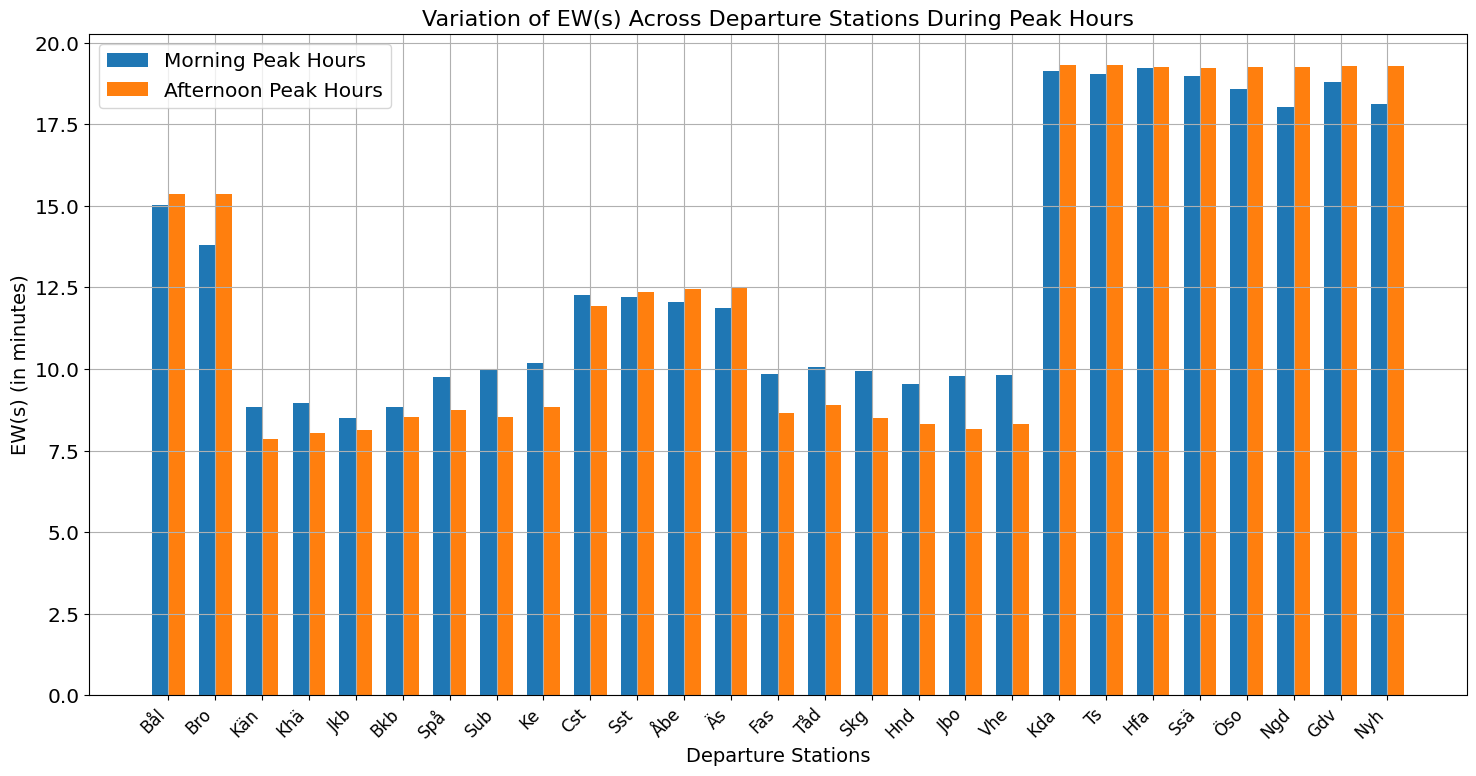

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# List of stations from south to north
stations_south_to_north = ['Bål', 'Bro', 'Kän', 'Khä', 'Jkb', 'Bkb', 'Spå', 'Sub', 'Ke', 'Cst', 'Sst', 'Åbe', 'Äs',
                           'Fas', 'Tåd', 'Skg', 'Hnd', 'Jbo', 'Vhe', 'Kda', 'Ts', 'Hfa', 'Ssä', 'Öso', 'Ngd', 'Gdv', 'Nyh']

# Calculate EW for all stations
ew_morning_list = []
ew_afternoon_list = []

for station in stations_south_to_north:
    ew_morning = calculate_ew(df_travel_times_actual_morning, station)
    ew_afternoon = calculate_ew(df_travel_times_actual_afternoon, station)
    ew_morning_list.append(ew_morning)
    ew_afternoon_list.append(ew_afternoon)

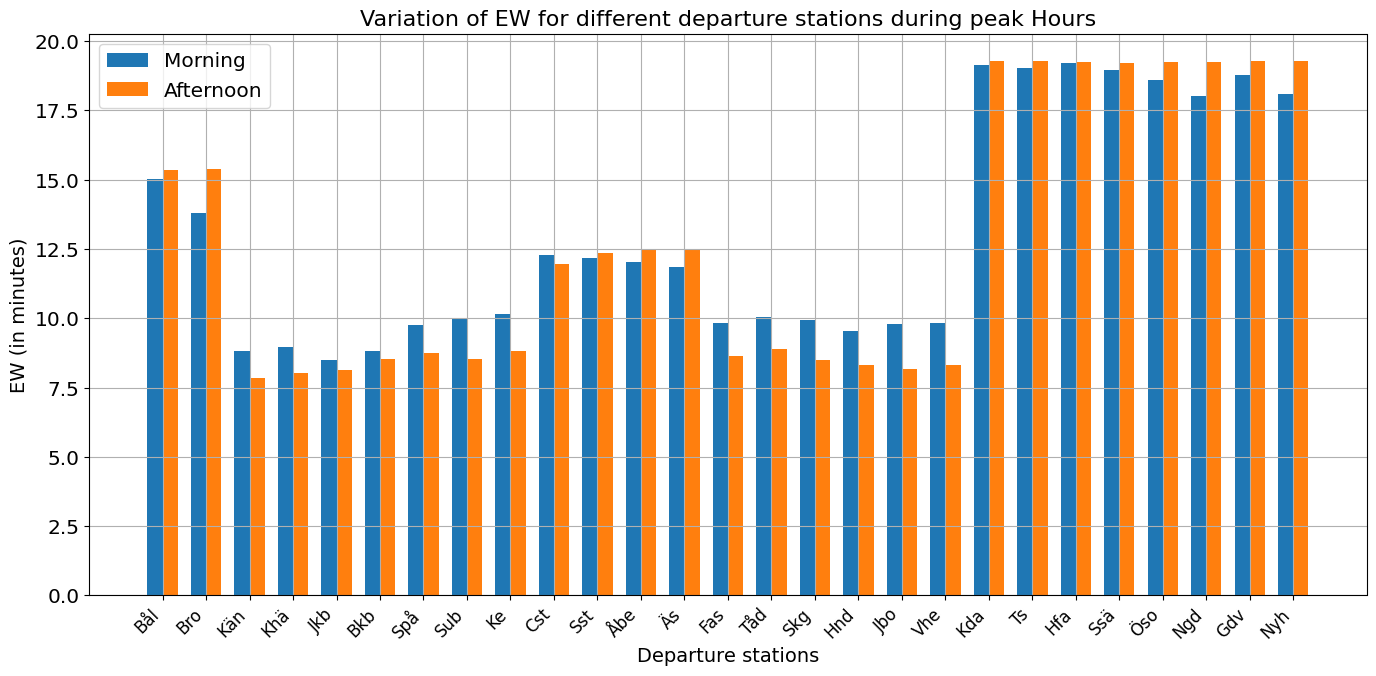

In [22]:
# Plotting
x = np.arange(len(stations_south_to_north))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 7))

# Plot bars for morning and afternoon EW
rects1 = ax.bar(x - width/2, ew_morning_list, width, label='Morning')
rects2 = ax.bar(x + width/2, ew_afternoon_list, width, label='Afternoon')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Departure stations', fontsize=14)
ax.set_ylabel('EW (in minutes)', fontsize=14)
ax.set_title('Variation of EW for different departure stations during peak Hours', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(stations_south_to_north, rotation=45, ha="right", fontsize=12)
ax.legend(fontsize=12)

# Add a grid
ax.grid(True)

# Add a legend
ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [24]:
import statistics

# Calculate and print the mean value for each list
print(statistics.mean(ew_morning_list))
print(statistics.mean(ew_afternoon_list))

13.003608052968858
12.720070040915433
